#Import

In [107]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
import sys

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import roc_auc_score, roc_curve, auc

%matplotlib inline

from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


#Format

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

#Functions

In [79]:
def count_auroc(model, X_train, X_val, train_targets, val_targets):
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_val_prob = model.predict_proba(X_val)[:, 1]

    train_auc = roc_auc_score(train_targets, y_train_prob)
    val_auc = roc_auc_score(val_targets, y_val_prob)

    return  train_auc, val_auc

def area_under_ROC(model, X_train, X_val, train_targets, val_targets):
    train_auc, val_auc = count_auroc(model, X_train, X_val, train_targets, val_targets)

    print(f'Train AUC: {train_auc:.4f}')
    print(f'Validation AUC: {val_auc:.4f}')

    return train_auc, val_auc

def max_depth_error(md, X_train, X_val, train_targets, val_targets):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_auc, val_auc = count_auroc(model, X_train, X_val, train_targets, val_targets)
    return {'Max Depth': md, 'Training AUROC': train_auc, 'Validation AUROC': val_auc}

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням Decision Trees і зробимо новий submission на змагання на Kaggle.

В цьому ДЗ ми працюємо без pipelines, бо так буде зручніше для візуалізації і інтерпретації моделі дерева прийняття рішень. Так буває і в робочих проєктах: іноді зручніше використати sklearn.Pipelines, іноді зручніше без них. На етапі пошуку рішення (research) зручніше без пайплайнів, а з пайплайнами - коли ви відлагодили процес обробки даних і хочете поекспериментувати з різними моделями і гіперпараметрами.

#1

**Завдання 1.**

У попередньому домашньому завданні, `HW 2.7 Логістична регресія з scikit learn.ipynb`, ми писали обробку даних для змагання. Ваше завдання зараз - за прикладом, наведеним в лекції `Майстер-клас з перенесення коду з jupyter notebook у Python модуль`, перенести попередню обробку сирих даних з вашого розв'язку ДЗ 2.7 у файл `process_bank_churn.py` в функцію `preprocess_data(...)`.

Функція `preprocess_data()` має приймати `raw_df` і вертати `X_train`, `train_targets`, `X_val`, `val_targets`, `input_cols`(перелік назв колонок, які Ви використовуєте в X), `scaler`, `encoder`, які ми потім будемо використовувати для тренування дерева прийняття рішень.


### Кроки попередньої обробки:

1. Обираємо колонки для роботи. В цьому завдання для чистоти експериментів рекомендую прибрати колонку `Surname`, так буде простіше інтрепретувати модель. Ви можете її додати вже за самостійних подальших експериментів.
2. Розбиття сирих даних на тренувальні і валідаційні.
3. Обробка категоріальних даних (one hot encoding).
4. Масштабування числових даних (було частиною попередньої обробки в попередніх завданнях). Для дерев нам не обовʼязково масштабувати ознаки, тож в коді можна зробити цю частину опціональною, додавши в `preprocess_data` параметр `scaler_numeric`, який приймає значення `True` або `False`. Це дозволить використовувати код попередньоъ обробки з різними моделями.


### Інструкції:
1. Перенесіть попередню обробку даних у файл `process_bank_churn.py`.
2. Забезпечте модулярну структуру функцій: кожна функція повинна виконувати лише одну дію, наприклад, масштабувати ознаки.
3. Додайте докстрінги до кожної функції.
4. Використовуйте typing для аргументів та значень, що повертаються функціями.
5. Передбачте обробку нових даних. Додайте спеціальну функцію `preprocess_new_data(...)`, яка приймає на вхід нові дані в вигляді pandas DataFrame та використовує вже навчені скейлер та енкодер (передані теж як аргументи фукнціх) для їх обробки. Ця функція буде корисною для обробки нових даних перед передбаченням або оцінкою моделі, коли оброблятимемо `test.csv`.

Можна і рекомендовано виконувати це завдання з ChatGPT (бажано, новіше, ніж 3.5) як було наведено у відео-прикладі, тільки **ваше додаткове завдання - розібратись з кодом, який вам згенерувала мовна модель :)**.

## В результаті цього завдання

1. Завантажте ваш готовий `process_bank_churn.py` файл на GitHub у свій репозиторій.
2. Додайте посилання на файл в репозиторії тут у ноутбуці.
3. Нижче зробіть імпорт функції `preprocess_data` з вашого модуля `process_bank_churn.py`.



##Зчитування даних

In [108]:
raw_df = pd.read_csv('//content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/train.csv.zip')

Посилання на репозиторій:
https://github.com/TNiklska/ML_homeworks/blob/main/process_bank_churn.py

##Попередня обробка даних

In [109]:
sys.path.append('/content/drive/MyDrive/Python/ML/HW_ML')
from process_bank_churn import get_processed_data, preprocess_new_data

In [110]:
X_train, X_val, train_targets, val_targets, model_cols, scaler, encoder, numeric_cols, encoded_cols, categorical_cols = get_processed_data(raw_df)

#2

**Завдання 2.**
1. Натренуйте дерево прийняття рішень з зафіксованим `random_state` і з рештою аргументів за замовченням.
2. Виведіть area under ROC для моделі на тренувальних і тестувальних даних. Нам потрібна ця метрика, бо вона основна в змаганні. Модель ок, чи є пере- або недотренування?
3. Виведіть глибину дерева.
4. Побудуйте дерево до глибини 2 включно. Напишіть, які ознаки бачите, що є найвпливовішими тут?
5. Створіть датафрейм `importance_df` з feature importances, де в першому стовпчику `feature` - назва ознаки з нашого Х, а в другому `importance` - значення, наскільки ця ознака є важливою в побудованій моделі. Виведіть топ 10 найвпливовіших ознак разом з їх скором важливості (можна або у вигляді таблиці, або в вигляді barplot).

###Звичайна модель

In [9]:
#2.1 тренування моделі
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, train_targets)

DecisionTreeClassifier(random_state=42)

In [10]:
#2.2 area under ROC
area_under_ROC(model, X_train, X_val, train_targets, val_targets)

Train AUC: 1.0000
Validation AUC: 0.7748


(1.0, 0.7747650730502778)

Оскільки AUC на тренувальному наборі даних 1, а на валідаційному 0.77, це свідчить про перенавчання моделі

In [11]:
#глибина дерева
model.tree_.max_depth

25

###Модель з глибиною 2

In [12]:
#тренування моделі
model_2 = DecisionTreeClassifier(max_depth=2, random_state=42)
model_2.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [13]:
#area under ROC
area_under_ROC(model_2, X_train, X_val, train_targets, val_targets)

Train AUC: 0.8438
Validation AUC: 0.8431


(0.8438440366406469, 0.8431264147060842)

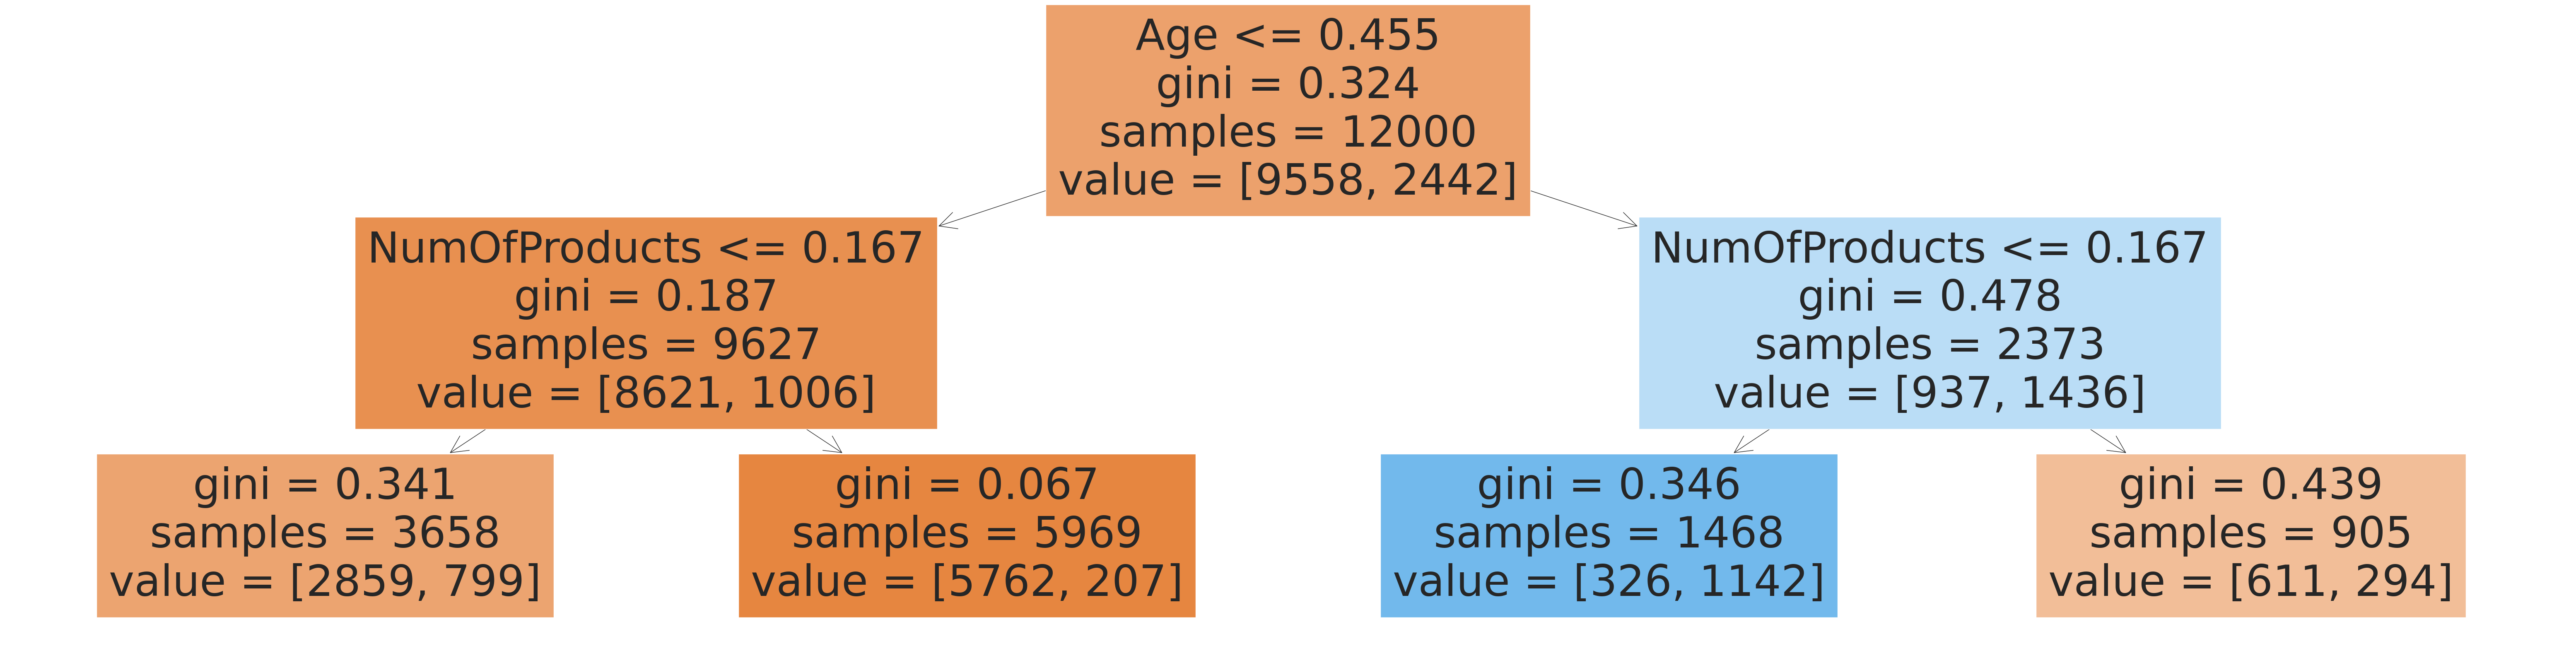

In [14]:
plt.figure(figsize=(80,20))
plot_tree(model_2, feature_names=X_train.columns, max_depth=2, filled=True);

Відповідно до візуалізації найголовнішими ознаками модель визначила вік клієнта та кількість наявних продуктів.

###Датафрейм importance_df

Для виводу важливості ознак я обрала модель з глибиною 21

In [15]:
model.feature_importances_.round(2)

array([0.11, 0.34, 0.05, 0.09, 0.17, 0.01, 0.04, 0.14, 0.  , 0.01, 0.  ,
       0.01, 0.  , 0.  , 0.01, 0.01, 0.  , 0.01])

In [16]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

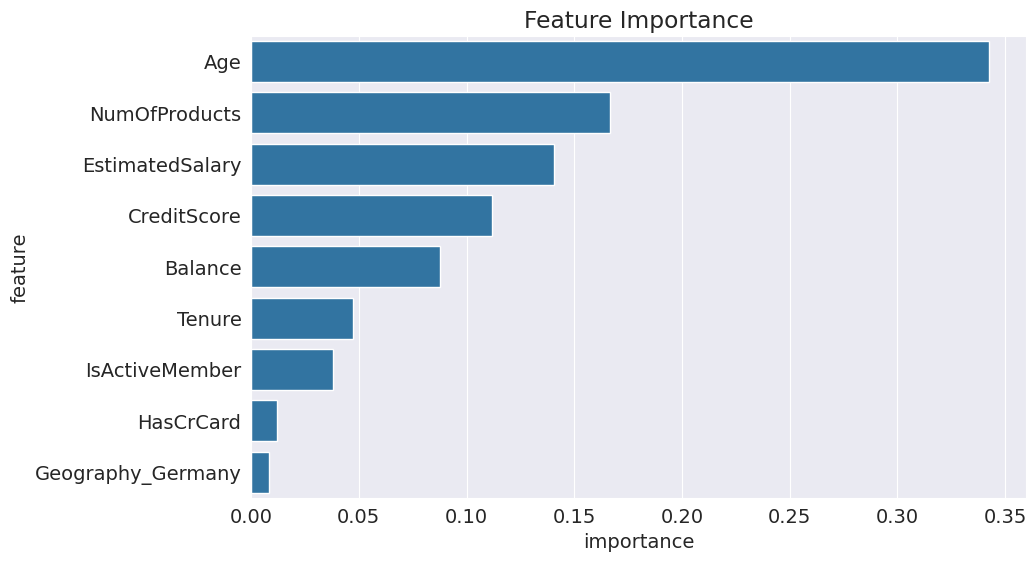

In [17]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

#3

**Завдання 3**. Спробуйте знайти такі параметри моделі `DecisionTree` аби модель генералізувала ліпше (був вищий показник AUROC на валідаційній вибірці). Проекспериментуйте з різними значеннями параметрів `max_leaf_nodes`, `max_depth` та лишіть ті, які дають найкращий результат, разом з відповідними AUROC на тренувальній і валідаційній вибірках.

В цьому завданні спробуйте просто знайти параметри методом "тика" :)

###depth5 !Train AUC: 0.9246, Validation AUC: 0.9224

In [18]:
#тренування моделі
model_3 = DecisionTreeClassifier(max_depth=5, random_state=42)
model_3.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [19]:
#area under ROC
area_under_ROC(model_3, X_train, X_val, train_targets, val_targets)

Train AUC: 0.9246
Validation AUC: 0.9224


(0.9245929074083499, 0.9224175183483092)

###depth6

In [59]:
#тренування моделі
model_3_2 = DecisionTreeClassifier(max_depth=6, random_state=42)
model_3_2.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=6, random_state=42)

In [60]:
#area under ROC
area_under_ROC(model_3_2, X_train, X_val, train_targets, val_targets)

Train AUC: 0.9335
Validation AUC: 0.9183


(0.9335030759230382, 0.918340764112765)

###leaf_nodes 200

In [20]:
model_4 = DecisionTreeClassifier(max_leaf_nodes=200, random_state=42)
model_4.fit(X_train, train_targets)

DecisionTreeClassifier(max_leaf_nodes=200, random_state=42)

In [23]:
#area under ROC
area_under_ROC(model_4, X_train, X_val, train_targets, val_targets)

Train AUC: 0.9457
Validation AUC: 0.8895


(0.9457477294106296, 0.889532889772961)

###leaf_nodes 100

In [35]:
model_5 = DecisionTreeClassifier(max_leaf_nodes=100, random_state=42)
model_5.fit(X_train, train_targets)

DecisionTreeClassifier(max_leaf_nodes=100, random_state=42)

In [36]:
#area under ROC
area_under_ROC(model_5, X_train, X_val, train_targets, val_targets)

Train AUC: 0.9366
Validation AUC: 0.9128


(0.9365961364548936, 0.9128088346251457)

###leaf_nodes 75

In [37]:
model_6 = DecisionTreeClassifier(max_leaf_nodes=75, random_state=42)
model_6.fit(X_train, train_targets)

DecisionTreeClassifier(max_leaf_nodes=75, random_state=42)

In [38]:
#area under ROC
area_under_ROC(model_6, X_train, X_val, train_targets, val_targets)

Train AUC: 0.9341
Validation AUC: 0.9160


(0.9341387055605511, 0.9160021263461142)

###leaf_nodes 25 !Train AUC: 0.9192, Validation AUC: 0.9188

In [55]:
model_7 = DecisionTreeClassifier(max_leaf_nodes=25, random_state=42)
model_7.fit(X_train, train_targets)

DecisionTreeClassifier(max_leaf_nodes=25, random_state=42)

In [56]:
#area under ROC
area_under_ROC(model_7, X_train, X_val, train_targets, val_targets)

Train AUC: 0.9192
Validation AUC: 0.9188


(0.9192289147562216, 0.9187711777213801)

**Висновки:**

 Найкращими параметрами стали:
- max_leaf_nodes 25:Train AUC: 0.9192, Validation AUC: 0.9188;
- max_depth5: Train AUC: 0.9246, Validation AUC: 0.9224

#4

**Завдання 4**. В циклі пройдіться по значенням max_depth від 1 до 20 включно, на кожній ітерації натренуйте DecisionTree модель і виміряйте AUROC на трейн і валідаційних даних.

В кінці виведіть на графік залеєність між AUROC на трейн і валідаційних даних і номером ітерації.

In [64]:
errors_df = pd.DataFrame([max_depth_error(md, X_train, X_val, train_targets, val_targets) for md in range(1, 21)])

In [67]:
errors_df.style.background_gradient(subset='Validation AUROC', cmap='Blues')

,Max Depth,Training AUROC,Validation AUROC
0,1,0.745005,0.733747
1,2,0.843844,0.843126
2,3,0.898620,0.893736
3,4,0.911807,0.907608
4,5,0.924593,0.922418
5,6,0.933503,0.918341
6,7,0.940658,0.912859
7,8,0.949063,0.894627
8,9,0.959578,0.878181
9,10,0.969028,0.873315


**Висновки:**
найкраще себе показала модель дерева прийняття рішень з глибиною 5: Validation AUROC = 0.922418. При тренуванні тотожної моделі в 4 завданні результат був Validation AUC: 0.9224. Що нормально для такої моделі, бо однією з ознак є нестійкість.

#5

**Завдання 5**.
1. Натренуйте модель `DecisionTree` з найкращим значенням `max_depth`, яке ви знайшли на попередній ітерації.
2. Завантажте тестові дані змагання з `test.csv`.
3. Зробіть попередню обробку даних з функцією `preprocess_new_data` з вашого модуля `process_bank_churn.py`.
4. Зробіть передбачення використовуючи цю модель на тестових даних змагання.
5. Сформуйте `submission.csv`.
6. Зробіть новий Submission на Kaggle і додайте тут скріншот Вашого скору на паблік лідерборді :)


In [68]:
#тренування моделі
model_5_1 = DecisionTreeClassifier(max_depth=5, random_state=42)
model_5_1.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [111]:
#завантаження тестових даних
test_raw_df = pd.read_csv('//content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/test.csv')

In [113]:
#попередня обробка тестових даних
X_test = preprocess_new_data(test_raw_df, scaler, encoder, numeric_cols, categorical_cols, encoded_cols, model_cols)

In [118]:
#передбачення на тестових даних
test_raw_df['Exited'] = model_5_1.predict_proba(X_test)[:,1]

In [120]:
ss = pd.read_csv('/content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/sample_submission.csv')

In [121]:
ss['Exited'] = ss['id'].map(test_raw_df.set_index('id')['Exited'])

In [123]:
ss.to_csv('/content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/submission_tree.csv', index=False)

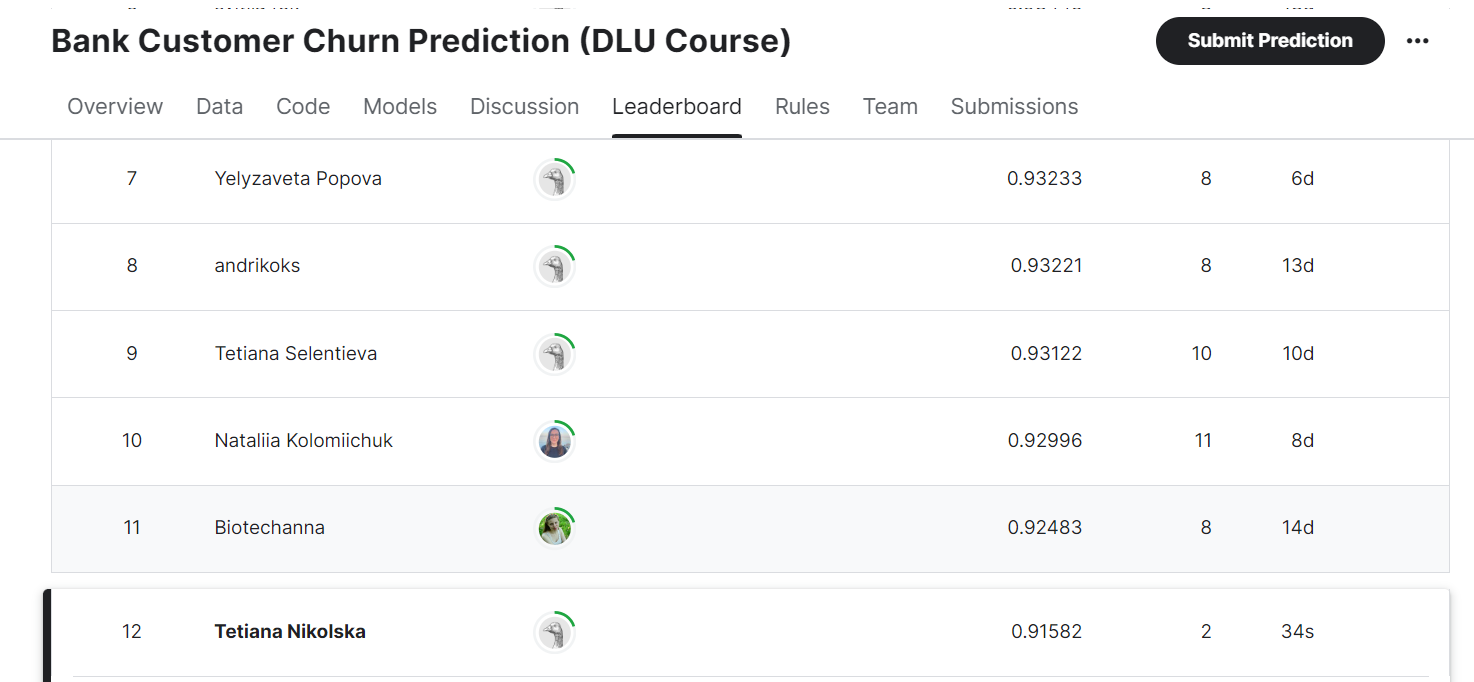